# Euan Barlow DAIP 3

The following code creates four linear regression models:

1. Base Model: Independent Variables are IsHoliday, Temperature, Month and the Dependent Variable is Weekly_Sales
2. Added Stores as Dummy Variables
3. Added Stores and Type as Dummy Variables
4. Added Stores, Type and Dept. as Dummy Variables

#### Source 
https://www.youtube.com/watch?v=BFgbfk3LYtw

### 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoLars, BayesianRidge, HuberRegressor, ARDRegression, PassiveAggressiveRegressor

### 2. Load Datasets

In [2]:
data_by_dept = pd.read_csv("data/data_by_dept.csv")
data_by_store = pd.read_csv("data/data_by_store.csv")
data_by_store_type = pd.read_csv("data/data_by_store.csv")
data_by_week = pd.read_csv("data/data_by_week.csv")
data_by_week_with_means = pd.read_csv("data/data_by_week_with_means.csv")

#### Sort by dates

In [3]:
data_by_dept['Date'] = pd.to_datetime(data_by_dept["Date"], format='%d/%m/%Y')
data_by_dept = data_by_dept.sort_values(['Date','Store','Dept']).reset_index().drop(columns='index')
data_by_store['Date'] = pd.to_datetime(data_by_store["Date"], format='%d/%m/%Y')
data_by_store = data_by_store.sort_values(['Date','Store']).reset_index().drop(columns='index')
data_by_store_type['Date'] = pd.to_datetime(data_by_store_type["Date"], format='%d/%m/%Y')
data_by_store_type = data_by_store_type.sort_values(['Date','Store']).reset_index().drop(columns='index')
data_by_week['Date'] = pd.to_datetime(data_by_week["Date"], format='%d/%m/%Y')
data_by_week = data_by_week.sort_values(['Date']).reset_index().drop(columns='index')
data_by_week_with_means['Date'] = pd.to_datetime(data_by_week_with_means["Date"], format='%d/%m/%Y')
data_by_week_with_means = data_by_week_with_means.sort_values(['Date']).reset_index().drop(columns='index')

### 3. Data Exploration

In [4]:
data_by_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          6435 non-null   datetime64[ns]
 1   Store         6435 non-null   int64         
 2   IsHoliday     6435 non-null   bool          
 3   Temperature   6435 non-null   float64       
 4   Fuel_Price    6435 non-null   float64       
 5   MarkDown1     2280 non-null   float64       
 6   MarkDown2     1637 non-null   float64       
 7   MarkDown3     2046 non-null   float64       
 8   MarkDown4     1965 non-null   float64       
 9   MarkDown5     2295 non-null   float64       
 10  CPI           6435 non-null   float64       
 11  Unemployment  6435 non-null   float64       
 12  Type          6435 non-null   object        
 13  Size          6435 non-null   int64         
 14  Weekly_Sales  6435 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64

### 4. Base Model Linear Regression - "Data by week with means"

#### Data Exploration

In [5]:
data_by_week_with_means.head()

,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales
0,2010-02-05,False,33.277942,2.717869,NaN,NaN,NaN,NaN,NaN,167.398405,8.576731,49750740.50
1,2010-02-12,True,33.361810,2.696102,NaN,NaN,NaN,NaN,NaN,167.384138,8.567309,48336677.63
2,2010-02-19,False,37.038310,2.673666,NaN,NaN,NaN,NaN,NaN,167.338966,8.576351,48276993.78
3,2010-02-26,False,38.629563,2.685642,NaN,NaN,NaN,NaN,NaN,167.691019,8.561375,43968571.13
4,2010-03-05,False,42.373998,2.731816,NaN,NaN,NaN,NaN,NaN,167.727351,8.572689,46871470.30


#### Data Manipulation - Drop Markdown Columns

In [6]:
# drop markdown columns
data_by_week_with_means = data_by_week_with_means.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"], 1)

#### Data Manipulation - Introduce Lag Variables

In [7]:
# create last 4 weeks lag variables (based on ARMA benchmark test findings)
for i in range(1,5):
    column_name = "y-" + str(i)
    data_by_week_with_means[column_name] = data_by_week_with_means["Weekly_Sales"].shift(i)
data_by_week_with_means = data_by_week_with_means.dropna()
data_by_week_with_means 

,Date,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,y-1,y-2,y-3,y-4
4,2010-03-05,False,42.373998,2.731816,167.727351,8.572689,46871470.30,43968571.13,48276993.78,48336677.63,49750740.50
5,2010-03-12,False,46.967143,2.774452,167.504162,8.580858,45925396.51,46871470.30,43968571.13,48276993.78,48336677.63
6,2010-03-19,False,49.481019,2.816063,167.478101,8.571996,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78
7,2010-03-26,False,47.979325,2.823610,167.510338,8.575041,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13
8,2010-04-02,False,52.587887,2.825453,167.377836,8.441092,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30
...,...,...,...,...,...,...,...,...,...,...,...
138,2012-09-28,False,68.151759,3.858245,175.919639,7.225855,43734899.40,44354547.11,44226038.65,48330059.31,47159639.43
139,2012-10-05,False,65.456811,3.848435,175.998254,6.942141,47566639.31,43734899.40,44354547.11,44226038.65,48330059.31
140,2012-10-12,False,57.687284,3.897425,176.123786,6.952682,46128514.25,47566639.31,43734899.40,44354547.11,44226038.65
141,2012-10-19,False,60.152756,3.878413,176.295499,6.948928,45122410.57,46128514.25,47566639.31,43734899.40,44354547.11


#### Data Manipulation - Year and Month

In [8]:
# create columns for year and month, drop date column
data_by_week_with_means['Year'] = pd.DatetimeIndex(data_by_week_with_means['Date']).year
data_by_week_with_means['Month'] = pd.DatetimeIndex(data_by_week_with_means['Date']).month

data_by_week_with_means = data_by_week_with_means.drop('Date', 1)
data_by_week_with_means

,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,y-1,y-2,y-3,y-4,Year,Month
4,False,42.373998,2.731816,167.727351,8.572689,46871470.30,43968571.13,48276993.78,48336677.63,49750740.50,2010,3
5,False,46.967143,2.774452,167.504162,8.580858,45925396.51,46871470.30,43968571.13,48276993.78,48336677.63,2010,3
6,False,49.481019,2.816063,167.478101,8.571996,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78,2010,3
7,False,47.979325,2.823610,167.510338,8.575041,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,2010,3
8,False,52.587887,2.825453,167.377836,8.441092,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,2010,4
...,...,...,...,...,...,...,...,...,...,...,...,...
138,False,68.151759,3.858245,175.919639,7.225855,43734899.40,44354547.11,44226038.65,48330059.31,47159639.43,2012,9
139,False,65.456811,3.848435,175.998254,6.942141,47566639.31,43734899.40,44354547.11,44226038.65,48330059.31,2012,10
140,False,57.687284,3.897425,176.123786,6.952682,46128514.25,47566639.31,43734899.40,44354547.11,44226038.65,2012,10
141,False,60.152756,3.878413,176.295499,6.948928,45122410.57,46128514.25,47566639.31,43734899.40,44354547.11,2012,10


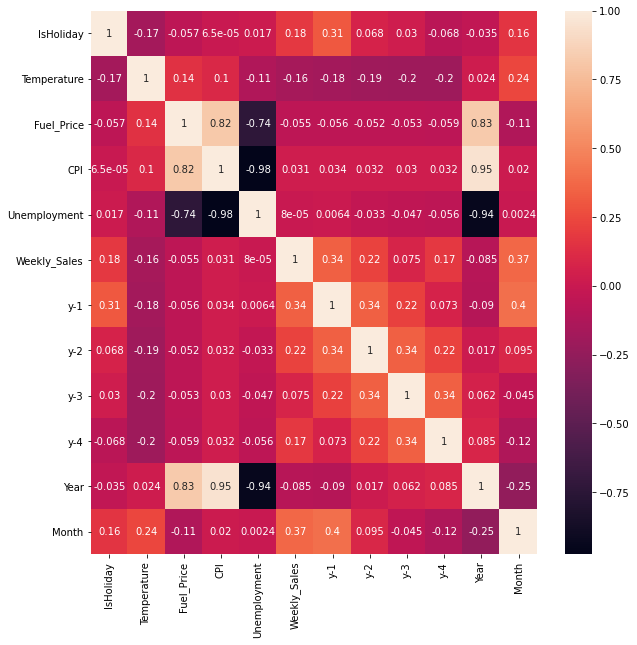

In [9]:
# numerical correlation
plt.figure(figsize=(10,10))
corr = data_by_week_with_means.corr()
sns.heatmap(corr, annot=True)
plt.show()

Year should not be used, and unemployment, CPI and fuel price show little correlation with Weekly Sales, so can be ignored

#### Split and Scale Data

In [10]:
training_set = data_by_week_with_means.copy().loc[(data_by_week_with_means['Year'].astype(int) != 2012) | 
                                                  (data_by_week_with_means['Month'].astype(int) < 2)]
testing_set = data_by_week_with_means.copy().loc[(data_by_week_with_means['Year'].astype(int) == 2012) & 
                                                 (data_by_week_with_means['Month'].astype(int) >= 2)]

In [11]:
y_train = training_set['Weekly_Sales'].copy()
X_train = training_set.drop(columns=['Weekly_Sales', 'Unemployment', 'CPI', 'Fuel_Price', 'Year']).copy()
y_test = testing_set['Weekly_Sales'].copy()
X_test = testing_set.drop(columns=['Weekly_Sales', 'Unemployment', 'CPI', 'Fuel_Price', 'Year']).copy()

In [12]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Linear Regression Model

In [13]:
lm_model = LinearRegression()

In [14]:
lm_model.fit(X_train, y_train)

LinearRegression()

Linear Regression R-squared:  -1.4848537778960158
Linear Regression RMSE:  3199370.31296455


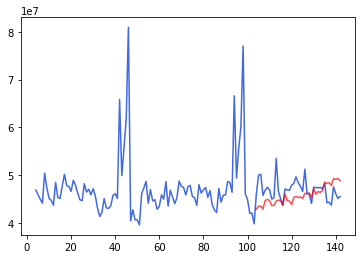

In [15]:
y_pred = lm_model.predict(X_test)
print("Linear Regression R-squared: ", lm_model.score(X_test, y_test))
print("Linear Regression RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
# plot model
plt.plot(training_set.append(testing_set).index, training_set.append(testing_set)['Weekly_Sales'], color='royalblue')
plt.plot(testing_set.index, y_pred, color='red', alpha=0.7)
plt.show()

#### Other Regression Models

LassoLars() R-squared:  -1.4848479721856789
LassoLars() RMSE:  3199366.575394897


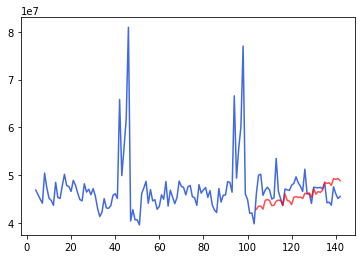

BayesianRidge() R-squared:  -0.009870741781180081
BayesianRidge() RMSE:  2039609.3152767813


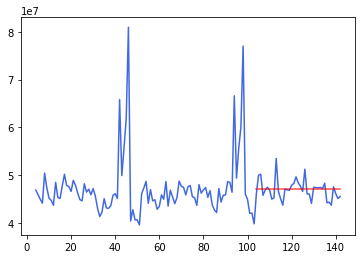

ARDRegression() R-squared:  -0.009870741781180081
ARDRegression() RMSE:  2039609.3152767813


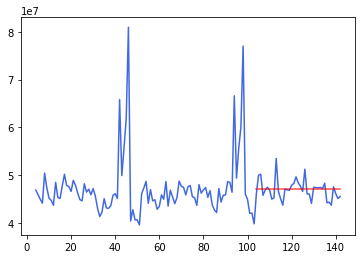

PassiveAggressiveRegressor(max_iter=1000000) R-squared:  -0.5951202101261486
PassiveAggressiveRegressor(max_iter=1000000) RMSE:  2563367.06844682


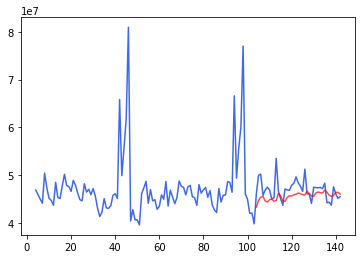

HuberRegressor() R-squared:  -0.2706142705131991
HuberRegressor() RMSE:  2287815.279638371


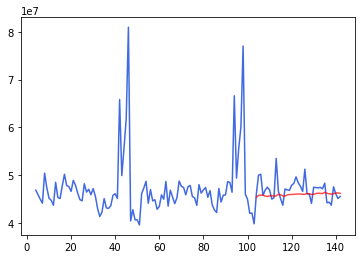

In [16]:
models = [LassoLars(), BayesianRidge(), ARDRegression(), PassiveAggressiveRegressor(max_iter=1000000), HuberRegressor()]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model, "R-squared: ", model.score(X_test, y_test))
    print(model, "RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
    
    # plot model
    plt.plot(training_set.append(testing_set).index, training_set.append(testing_set)['Weekly_Sales'], color='royalblue')
    plt.plot(testing_set.index, y_pred, color='red', alpha=0.7)
    plt.show()

### 5. Linear Regression - "Data by Store"

#### Data Manipulation - Drop Markdown Columns

In [17]:
data_by_store = data_by_store.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"], 1)

#### Data Manipulation - Introduce Lag Variables

In [18]:
# create last 4 weeks lag variables (based on ARMA benchmark test findings)
# split date by stores
# list of stores
stores = data_by_store["Store"].unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in stores}

# create previous 4 weeks of data (1 month)
dfList = []
for key in DataFrameDict.keys():
    DataFrameDict[key] = data_by_store[:][data_by_store["Store"] == key]
    for i in range(1,5):
        column_name = "y-" + str(i)
        DataFrameDict[key][column_name] = DataFrameDict[key]["Weekly_Sales"].shift(i)
    dfList.append(DataFrameDict[key])

# merge dataframes back
data_by_store = pd.concat(dfList).dropna()
data_by_store

,Date,Store,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Weekly_Sales,y-1,y-2,y-3,y-4
180,2010-03-05,1,False,46.50,2.625,211.350143,8.106,A,151315,1554806.68,1409727.59,1611968.17,1641957.44,1643690.90
225,2010-03-12,1,False,57.79,2.667,211.380643,8.106,A,151315,1439541.59,1554806.68,1409727.59,1611968.17,1641957.44
270,2010-03-19,1,False,54.58,2.720,211.215635,8.106,A,151315,1472515.79,1439541.59,1554806.68,1409727.59,1611968.17
315,2010-03-26,1,False,51.45,2.732,211.018042,8.106,A,151315,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59
360,2010-04-02,1,False,62.27,2.719,210.820450,7.808,A,151315,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254,2012-09-28,45,False,64.88,3.997,192.013558,8.684,B,118221,713173.95,723086.20,702238.27,766512.66,734297.87
6299,2012-10-05,45,False,64.89,3.985,192.170412,8.667,B,118221,733455.07,713173.95,723086.20,702238.27,766512.66
6344,2012-10-12,45,False,54.47,4.000,192.327265,8.667,B,118221,734464.36,733455.07,713173.95,723086.20,702238.27
6389,2012-10-19,45,False,56.47,3.969,192.330854,8.667,B,118221,718125.53,734464.36,733455.07,713173.95,723086.20


#### Data Manipulation - Drop Type Column

In [19]:
data_by_store = data_by_store.drop(["Type"], 1)

#### Data Manipulation - Year and Month

In [20]:
data_by_store['Year'] = pd.DatetimeIndex(data_by_store['Date']).year
data_by_store['Month'] = pd.DatetimeIndex(data_by_store['Date']).month

data_by_store = data_by_store.drop('Date', 1)

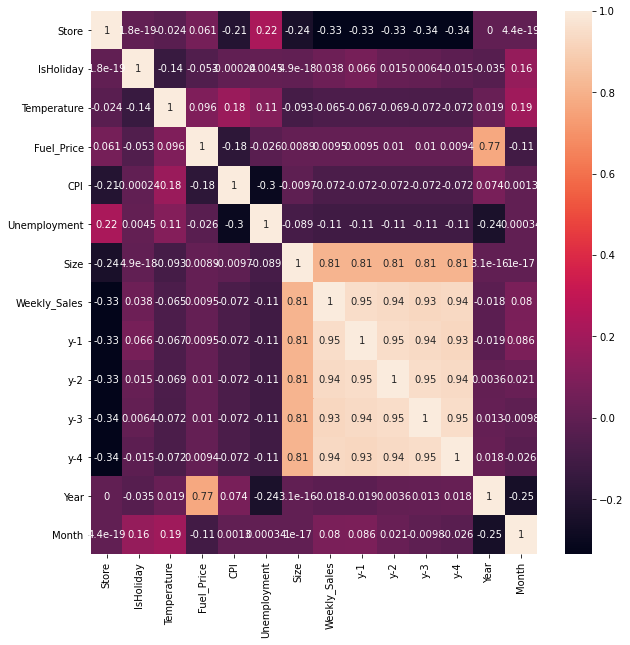

In [21]:
# numerical correlation
plt.figure(figsize=(10,10))
corr = data_by_store.corr()
sns.heatmap(corr, annot=True)
plt.show()

#### Data Manipulation - Create Dummies for Stores and Type

In [22]:
#create dummy function

def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies=pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [23]:
#dummies for stores

data_by_store = onehot_encode(data_by_store, column='Store', prefix="store")

In [24]:
data_by_store

,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Weekly_Sales,y-1,y-2,y-3,...,store_36,store_37,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45
180,False,46.50,2.625,211.350143,8.106,151315,1554806.68,1409727.59,1611968.17,1641957.44,...,0,0,0,0,0,0,0,0,0,0
225,False,57.79,2.667,211.380643,8.106,151315,1439541.59,1554806.68,1409727.59,1611968.17,...,0,0,0,0,0,0,0,0,0,0
270,False,54.58,2.720,211.215635,8.106,151315,1472515.79,1439541.59,1554806.68,1409727.59,...,0,0,0,0,0,0,0,0,0,0
315,False,51.45,2.732,211.018042,8.106,151315,1404429.92,1472515.79,1439541.59,1554806.68,...,0,0,0,0,0,0,0,0,0,0
360,False,62.27,2.719,210.820450,7.808,151315,1594968.28,1404429.92,1472515.79,1439541.59,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254,False,64.88,3.997,192.013558,8.684,118221,713173.95,723086.20,702238.27,766512.66,...,0,0,0,0,0,0,0,0,0,1
6299,False,64.89,3.985,192.170412,8.667,118221,733455.07,713173.95,723086.20,702238.27,...,0,0,0,0,0,0,0,0,0,1
6344,False,54.47,4.000,192.327265,8.667,118221,734464.36,733455.07,713173.95,723086.20,...,0,0,0,0,0,0,0,0,0,1
6389,False,56.47,3.969,192.330854,8.667,118221,718125.53,734464.36,733455.07,713173.95,...,0,0,0,0,0,0,0,0,0,1


#### Split and Scale Data

In [25]:
training_set = data_by_store.copy().loc[(data_by_store['Year'].astype(int) != 2012) | 
                                        (data_by_store['Month'].astype(int) < 7)]
testing_set = data_by_store.copy().loc[(data_by_store['Year'].astype(int) == 2012) & 
                                       (data_by_store['Month'].astype(int) >= 7)]

In [26]:
y_train = training_set['Weekly_Sales'].copy()
X_train = training_set.drop(columns=['Weekly_Sales', 'Unemployment', 'CPI', 'Fuel_Price', 'Year']).copy()
y_test = testing_set['Weekly_Sales'].copy()
X_test = testing_set.drop(columns=['Weekly_Sales', 'Unemployment', 'CPI', 'Fuel_Price', 'Year']).copy()

In [27]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Linear Regression Model

In [28]:
lm_model = LinearRegression()

In [29]:
lm_model.fit(X_train, y_train)

LinearRegression()

Linear Regression R-squared:  0.9749834358497995
Linear Regression RMSE:  83702.26987964174


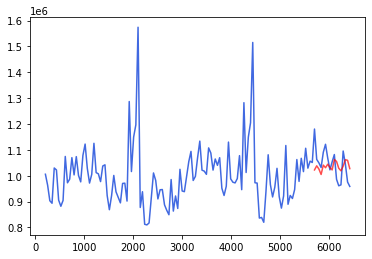

In [30]:
y_pred = lm_model.predict(X_test)
df = testing_set.copy()
df['y_pred'] = y_pred
df1 = training_set.append(df)
print("Linear Regression R-squared: ", lm_model.score(X_test, y_test))
print("Linear Regression RMSE: ", mean_squared_error(y_test, y_pred, squared=False))

# plot model
plt.plot(df1.loc[df1['store_26'] == True].index, df1.loc[df1['store_26'] == True]['Weekly_Sales'], color='royalblue')
plt.plot(df1.loc[df1['store_26'] == True].index, df1.loc[df1['store_26'] == True]['y_pred'], color='red', alpha=0.7)
plt.show()

#### Other Regression Models

LassoLars() R-squared:  0.9752494522881265
LassoLars() RMSE:  83256.05174831177


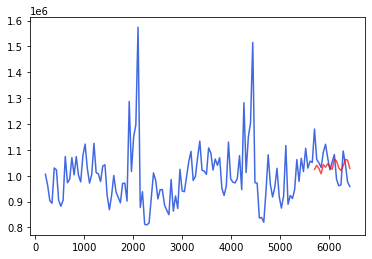

BayesianRidge() R-squared:  0.9752044699308082
BayesianRidge() RMSE:  83331.67337626062


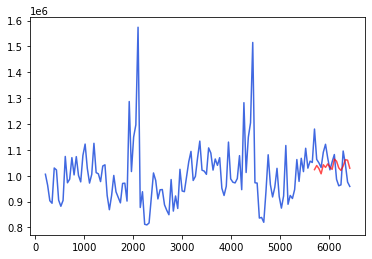

ARDRegression() R-squared:  0.9759504427497889
ARDRegression() RMSE:  82068.5853217765


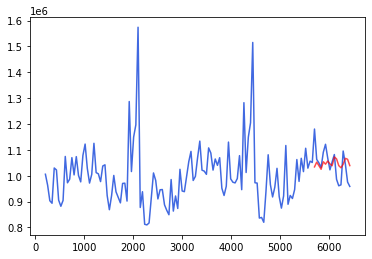

PassiveAggressiveRegressor(max_iter=100000) R-squared:  0.9806975375946382
PassiveAggressiveRegressor(max_iter=100000) RMSE:  73524.10762895063


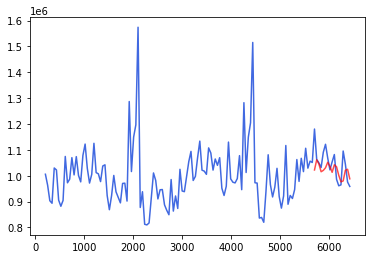

HuberRegressor() R-squared:  0.9800783576377989
HuberRegressor() RMSE:  74694.04416827013


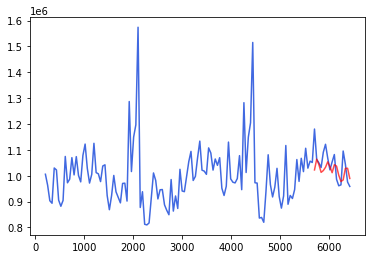

In [31]:
models = [LassoLars(), BayesianRidge(), ARDRegression(), PassiveAggressiveRegressor(max_iter=100000), HuberRegressor()]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    df = testing_set.copy()
    df['y_pred'] = y_pred
    df1 = training_set.append(df)
    print(model, "R-squared: ", model.score(X_test, y_test))
    print(model, "RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
    
    # plot model
    plt.plot(df1.loc[df1['store_26'] == True].index, df1.loc[df1['store_26'] == True]['Weekly_Sales'], color='royalblue')
    plt.plot(df1.loc[df1['store_26'] == True].index, df1.loc[df1['store_26'] == True]['y_pred'], color='red', alpha=0.7)
    plt.show()

### 6. Linear Regression - "Data by Store and Type"

#### Data Manipulation - Drop Markdown Columns

In [32]:
data_by_store_type = data_by_store_type.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"], 1)

#### Data Manipulation - Introduce Lag Variables

In [33]:
# create last 4 weeks lag variables (based on ARMA benchmark test findings)
# split date by stores
# list of stores
stores = data_by_store_type["Store"].unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame for elem in stores}

# create previous 4 weeks of data (1 month)
dfList = []
for key in DataFrameDict.keys():
    DataFrameDict[key] = data_by_store_type[:][data_by_store_type["Store"] == key]
    for i in range(1,5):
        column_name = "y-" + str(i)
        DataFrameDict[key][column_name] = DataFrameDict[key]["Weekly_Sales"].shift(i)
    dfList.append(DataFrameDict[key])

# merge dataframes back
data_by_store_type = pd.concat(dfList).dropna()
data_by_store_type

,Date,Store,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Weekly_Sales,y-1,y-2,y-3,y-4
180,2010-03-05,1,False,46.50,2.625,211.350143,8.106,A,151315,1554806.68,1409727.59,1611968.17,1641957.44,1643690.90
225,2010-03-12,1,False,57.79,2.667,211.380643,8.106,A,151315,1439541.59,1554806.68,1409727.59,1611968.17,1641957.44
270,2010-03-19,1,False,54.58,2.720,211.215635,8.106,A,151315,1472515.79,1439541.59,1554806.68,1409727.59,1611968.17
315,2010-03-26,1,False,51.45,2.732,211.018042,8.106,A,151315,1404429.92,1472515.79,1439541.59,1554806.68,1409727.59
360,2010-04-02,1,False,62.27,2.719,210.820450,7.808,A,151315,1594968.28,1404429.92,1472515.79,1439541.59,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254,2012-09-28,45,False,64.88,3.997,192.013558,8.684,B,118221,713173.95,723086.20,702238.27,766512.66,734297.87
6299,2012-10-05,45,False,64.89,3.985,192.170412,8.667,B,118221,733455.07,713173.95,723086.20,702238.27,766512.66
6344,2012-10-12,45,False,54.47,4.000,192.327265,8.667,B,118221,734464.36,733455.07,713173.95,723086.20,702238.27
6389,2012-10-19,45,False,56.47,3.969,192.330854,8.667,B,118221,718125.53,734464.36,733455.07,713173.95,723086.20


#### Data Manipulation - Year and Month

In [34]:
data_by_store_type['Year'] = pd.DatetimeIndex(data_by_store_type['Date']).year
data_by_store_type['Month'] = pd.DatetimeIndex(data_by_store_type['Date']).month

data_by_store_type = data_by_store_type.drop('Date', 1)

#### Data Manipulation - Create Dummies for Stores and Type

In [35]:
#create dummy function

def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies=pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [36]:
#dummies for stores

data_by_store_type = onehot_encode(data_by_store_type, column='Store', prefix="store")

In [37]:
#dummies for type

data_by_store_type = onehot_encode(data_by_store_type, column='Type', prefix="type")

In [38]:
data_by_store_type

,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Weekly_Sales,y-1,y-2,y-3,...,store_39,store_40,store_41,store_42,store_43,store_44,store_45,type_A,type_B,type_C
180,False,46.50,2.625,211.350143,8.106,151315,1554806.68,1409727.59,1611968.17,1641957.44,...,0,0,0,0,0,0,0,1,0,0
225,False,57.79,2.667,211.380643,8.106,151315,1439541.59,1554806.68,1409727.59,1611968.17,...,0,0,0,0,0,0,0,1,0,0
270,False,54.58,2.720,211.215635,8.106,151315,1472515.79,1439541.59,1554806.68,1409727.59,...,0,0,0,0,0,0,0,1,0,0
315,False,51.45,2.732,211.018042,8.106,151315,1404429.92,1472515.79,1439541.59,1554806.68,...,0,0,0,0,0,0,0,1,0,0
360,False,62.27,2.719,210.820450,7.808,151315,1594968.28,1404429.92,1472515.79,1439541.59,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254,False,64.88,3.997,192.013558,8.684,118221,713173.95,723086.20,702238.27,766512.66,...,0,0,0,0,0,0,1,0,1,0
6299,False,64.89,3.985,192.170412,8.667,118221,733455.07,713173.95,723086.20,702238.27,...,0,0,0,0,0,0,1,0,1,0
6344,False,54.47,4.000,192.327265,8.667,118221,734464.36,733455.07,713173.95,723086.20,...,0,0,0,0,0,0,1,0,1,0
6389,False,56.47,3.969,192.330854,8.667,118221,718125.53,734464.36,733455.07,713173.95,...,0,0,0,0,0,0,1,0,1,0


#### Split and Scale Data

In [39]:
training_set = data_by_store_type.copy().loc[(data_by_store_type['Year'].astype(int) != 2012) | 
                                                  (data_by_store_type['Month'].astype(int) < 7)]
testing_set = data_by_store_type.copy().loc[(data_by_store_type['Year'].astype(int) == 2012) & 
                                                 (data_by_store_type['Month'].astype(int) >= 7)]

In [40]:
y_train = training_set['Weekly_Sales'].copy()
X_train = training_set.drop(columns=['Weekly_Sales', 'Unemployment', 'CPI', 'Fuel_Price', 'Year']).copy()
y_test = testing_set['Weekly_Sales'].copy()
X_test = testing_set.drop(columns=['Weekly_Sales', 'Unemployment', 'CPI', 'Fuel_Price', 'Year']).copy()

In [41]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Linear Regression Model

In [42]:
lm_model = LinearRegression()

In [43]:
lm_model.fit(X_train, y_train)

LinearRegression()

Linear Regression R-squared:  0.9749568382076476
Linear Regression RMSE:  83746.75423760248


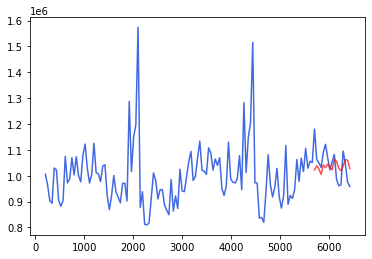

In [44]:
y_pred = lm_model.predict(X_test)
df = testing_set.copy()
df['y_pred'] = y_pred
df1 = training_set.append(df)
print("Linear Regression R-squared: ", lm_model.score(X_test, y_test))
print("Linear Regression RMSE: ", mean_squared_error(y_test, y_pred, squared=False))

# plot model
plt.plot(df1.loc[df1['store_26'] == True].index, df1.loc[df1['store_26'] == True]['Weekly_Sales'], color='royalblue')
plt.plot(df1.loc[df1['store_26'] == True].index, df1.loc[df1['store_26'] == True]['y_pred'], color='red', alpha=0.7)
plt.show()

#### Other Regression Models

LassoLars() R-squared:  0.9752494522881262
LassoLars() RMSE:  83256.05174831241


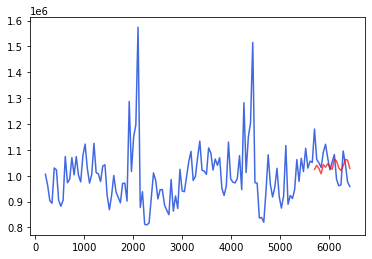

BayesianRidge() R-squared:  0.9751620277507708
BayesianRidge() RMSE:  83402.96174364672


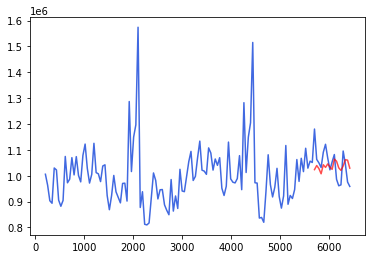

ARDRegression() R-squared:  0.9759914988574384
ARDRegression() RMSE:  81998.50386686772


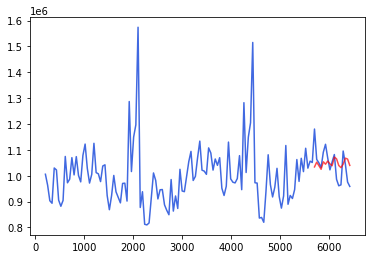

PassiveAggressiveRegressor(max_iter=100000) R-squared:  0.9804712776210707
PassiveAggressiveRegressor(max_iter=100000) RMSE:  73953.77033668997


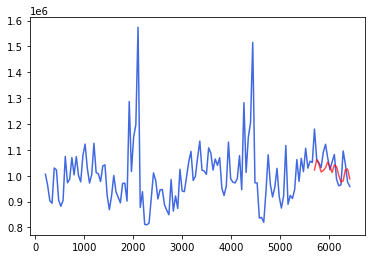

HuberRegressor() R-squared:  0.9800398831942804
HuberRegressor() RMSE:  74766.13726003109


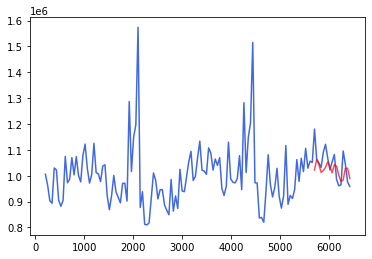

In [45]:
models = [LassoLars(), BayesianRidge(), ARDRegression(), PassiveAggressiveRegressor(max_iter=100000), HuberRegressor()]
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    df = testing_set.copy()
    df['y_pred'] = y_pred
    df1 = training_set.append(df)
    print(model, "R-squared: ", model.score(X_test, y_test))
    print(model, "RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
    
    # plot model
    plt.plot(df1.loc[df1['store_26'] == True].index, df1.loc[df1['store_26'] == True]['Weekly_Sales'], color='royalblue')
    plt.plot(df1.loc[df1['store_26'] == True].index, df1.loc[df1['store_26'] == True]['y_pred'], color='red', alpha=0.7)
    plt.show()

### 7. Linear Regression - "Data by Store, Type and Dept"

#### Data Exploration

In [51]:
data_by_dept.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,05/02/2010,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,12/02/2010,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,19/02/2010,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,26/02/2010,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,05/03/2010,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


#### Data Manipulation - Drop Markdown Columns

In [52]:
data_by_dept = data_by_dept.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"], 1)

#### Data Manipulation - Year and Month

In [53]:
data_by_dept['Year'] = data_by_dept['Date'].apply(lambda x: x[-4:])
data_by_dept['Month'] = data_by_dept['Date'].apply(lambda x: x[3:5])

data_by_dept = data_by_dept.drop('Date', 1)

#### Data Manipulation - Create Dummies for Stores, Type and Department

In [54]:
#create dummy function

def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies=pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [55]:
#dummies for stores

data_by_dept = onehot_encode(data_by_dept, column='Store', prefix="store")

In [56]:
#dummies for type

data_by_dept = onehot_encode(data_by_dept, column='Type', prefix="type")

In [57]:
#dummies for dept

data_by_dept = onehot_encode(data_by_dept, column='Dept', prefix="dept")

#### Split and Scale Data

In [ ]:
training_set = data_by_dept.copy().loc[(data_by_dept['Year'].astype(int) != 2012) | 
                                                  (data_by_dept['Month'].astype(int) < 9)]
testing_set = data_by_dept.copy().loc[(data_by_dept['Year'].astype(int) == 2012) & 
                                                 (data_by_dept['Month'].astype(int) >= 9)]

In [26]:
y_train = training_set['Weekly_Sales'].copy()
X_train = training_set.drop('Weekly_Sales', axis=1).copy()
y_test = testing_set['Weekly_Sales'].copy()
X_test = testing_set.drop('Weekly_Sales', axis=1).copy()

In [24]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Linear Regression Model

In [61]:
lm_model = LinearRegression()

In [62]:
lm_model.fit(X_train, y_train)

LinearRegression()

In [63]:
print("Linear Regression Accuracy:", lm_model.score(X_test, y_test))
print("Linear Regression RMSE: ", mean_squared_error(y_test, lm_model.predict(X_test), squared=False))

Linear Regression Accuracy: 0.6577099119728569
Linear Regression RMSE:  13219.208310381242


#### Other Regression Models

In [64]:
models = [LassoLars(), BayesianRidge(), ARDRegression(), PassiveAggressiveRegressor(), HuberRegressor()]
for model in models:
    model.fit(X_train, y_train)
    print(model, "Accuracy: ", model.score(X_test, y_test))
    print(model, "RMSE: ", mean_squared_error(y_test, model.predict(X_test), squared=False))

LassoLars() Accuracy:  0.6031971875385937
LassoLars() RMSE:  14232.973986968129
BayesianRidge() Accuracy:  0.6577445706844471
BayesianRidge() RMSE:  13218.539035484444
ARDRegression() Accuracy:  0.6577135871188199
ARDRegression() RMSE:  13219.137343309505
PassiveAggressiveRegressor() Accuracy:  0.6130834895341197
PassiveAggressiveRegressor() RMSE:  14054.549062590242
HuberRegressor() Accuracy:  0.6229089740626906
HuberRegressor() RMSE:  13874.948612421704
